## COVID Variant Trend Analysis Pipeline
* Sangwon Baek
* March 10th, 2023

In [1]:
import pandas as pd
import numpy as np
import re
import random as rn
import statistics 
from copy import deepcopy

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import kstest, norm, mannwhitneyu, chi2_contingency, fisher_exact, ttest_ind, zscore

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, cross_val_score, ParameterGrid, StratifiedKFold, KFold
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, f1_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve

from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay, partial_dependence
import shap
from lime import lime_tabular

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.calibration import calibration_curve
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, auc
from sklearn import metrics
from statsmodels.stats import contingency_tables
import statsmodels.api as sm

pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 100)

from decimal import Decimal

import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
import tensorflow.keras.backend as K
from tensorflow.keras.utils import normalize, to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from matplotlib.ticker import FuncFormatter

C:\Users\user\anaconda3\envs\swb_env_3.9\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Read csv file using pandas
df2 = pd.read_csv('../Data/Preprocessed/CRF_Initial.csv', low_memory=False)
df2 = df2.drop(columns='Unnamed: 0')

na_cols = ['UD_HT','UD_DM','UD_CVD','UD_cancer','UD_other','SMT_fever','SMT_cough','SMT_sputum','SMT_dyspnea',
          'SMT_myalgia', 'SMT_sorethroat', 'SMT_mental', 'SMT_GI', 'steroid']
df2[na_cols] = df2[na_cols].fillna(value=0)

#Remove D-Dimer from the dataframe
ColumnNames = ['No', 'ID', 'age', 'sex', 'dx_date', 'hospitalized_date', 'UD_HT', 'UD_DM', 'UD_CVD', 'UD_cancer',
              'UD_other', 'SMT_fever', 'SMT_cough', 'SMT_sputum', 'SMT_dyspnea', 'SMT_myalgia',
              'SMT_sorethroat', 'SMT_mental', 'SMT_GI', 'TX_0', 'TX_1', 'TX_2', 'TX_3', 'TX_4', 
               'Smoking_0', 'Smoking_1', 'Smoking_2', 'Smoking_3', 'BT', 'SBP', 
               'DBP', 'PR', 'RR', 'SPO2', 'WBC', 'ANC', 'ALC', 'PLT', 'CRP', 'LDH', 
               'DD', 'PCR', 'steroid', 'Mild','Moderate','Severe']
df2 = df2[ColumnNames].drop(columns = 'DD')
# Replace 'UD_' and 'SMT_' in the column names
new_column_names = {col: col.replace('UD_', '').replace('SMT_', '') for col in df2.columns}
# Rename the columns in the dataframe
df2 = df2.rename(columns=new_column_names)

In [3]:
#Convert hospitalized date to datetime object
df2.hospitalized_date = pd.to_datetime(df2.hospitalized_date)

#Create variant column and assign 'alpha', 'delta', 'omicron' accordingly
for index, row in df2.iterrows():
    hospitalized_date = row['hospitalized_date']
    #2020 January to 2021 April
    if hospitalized_date >= pd.to_datetime('2020-01-01') and hospitalized_date < pd.to_datetime('2021-05-06'):
        df2.at[index, 'variant'] = 'alpha'
    #2021 April to 2021 December
    elif hospitalized_date >= pd.to_datetime('2021-05-06') and hospitalized_date < pd.to_datetime('2021-11-24'):
        df2.at[index, 'variant'] = 'delta'
    #2021 November to 2022 
    elif hospitalized_date >= pd.to_datetime('2021-11-24') and hospitalized_date < pd.to_datetime('2022-10-31'):
        df2.at[index, 'variant'] = 'omicron' 

In [4]:
#Using the variant column results, separate datset into three predominant period
df_alpha = df2[df2.variant=='alpha']
df_delta = df2[df2.variant=='delta']
df_omicron = df2[df2.variant=='omicron']

# Take SCH (순천향대), JNU (전남대), SCN (세종충남대), SMC (삼성서울병원) for test set and the rest for trainset.
df2_train = df2.loc[~df2['ID'].isin(['SCH', 'SCN' 'SMC', 'JNU'])]
df2_test = df2.loc[df2['ID'].isin(['SCH', 'SCN' 'SMC', 'JNU'])]


In [5]:
# Take JNU (전남대), SCN (세종충남대), SMC (삼성서울병원), SCH (순천향대) for test set and the rest for trainset.
df_alpha_test = df_alpha.loc[df_alpha['ID'].isin(['SCH', 'SCN' 'SMC', 'JNU'])]
df_alpha_train = df_alpha.loc[~df_alpha['ID'].isin(['SCH', 'SCN' 'SMC', 'JNU'])]
df_delta_test = df_delta.loc[df_delta['ID'].isin(['SCH', 'SCN' 'SMC', 'JNU'])]
df_delta_train = df_delta.loc[~df_delta['ID'].isin(['SCH', 'SCN' 'SMC', 'JNU'])]
df_omicron_test = df_omicron.loc[df_omicron['ID'].isin(['SCH', 'SCN' 'SMC', 'JNU'])]
df_omicron_train = df_omicron.loc[~df_omicron['ID'].isin(['SCH', 'SCN' 'SMC', 'JNU'])]

#ALL data without Omicron train set (so Omicron can be tested all)
df_WO_Omicron = df2[~(df2.variant=='omicron')]
df_WO_Omicron_train = df2[~(df2.variant=='omicron')].loc[~df2['ID'].isin(['SCH', 'SCN' 'SMC', 'JNU'])]
df_WO_Omicron_test = df2[~(df2.variant=='omicron')].loc[df2['ID'].isin(['SCH', 'SCN' 'SMC', 'JNU'])]

#ALL data without Alpha train set (so Alpha can be tested all)
df_WO_Alpha = df2[~(df2.variant=='alpha')]
df_WO_Alpha_train = df2[~(df2.variant=='alpha')].loc[~df2['ID'].isin(['SCH', 'SCN' 'SMC', 'JNU'])]
df_WO_Alpha_test = df2[~(df2.variant=='alpha')].loc[df2['ID'].isin(['SCH', 'SCN' 'SMC', 'JNU'])]

#ALL data without Delta train set (so Delta can be tested all)
df_WO_Delta = df2[~(df2.variant=='delta')]
df_WO_Delta_train = df2[~(df2.variant=='delta')].loc[~df2['ID'].isin(['SCH', 'SCN' 'SMC', 'JNU'])]
df_WO_Delta_test = df2[~(df2.variant=='delta')].loc[df2['ID'].isin(['SCH', 'SCN' 'SMC', 'JNU'])]

print(len(df_alpha_test), len(df_alpha_train))
print(len(df_delta_test), len(df_delta_train))
print(len(df_omicron_test), len(df_omicron_train))

840 2622
628 1406
112 337


In [6]:
df_alpha.Severe.value_counts()

0    3066
1     396
Name: Severe, dtype: int64

In [7]:
df_delta.Severe.value_counts()

0    1761
1     273
Name: Severe, dtype: int64

In [8]:
df_omicron.Severe.value_counts()

0    279
1    170
Name: Severe, dtype: int64

In [9]:
def categorical_table_func(df, item, treatment):    
    T_Counts = len(df[df[item]==1]) 
    T_Percent = round(len(df[df[item]==1]) / (len(df))*100,1)
    T_s = '{:,} [{}%]'.format(T_Counts,T_Percent)
    
    P_patients = df.loc[df[treatment]==1]
    P_Counts = len(P_patients[P_patients[item]==1]) 
    P_Percent = round(P_Counts / (len(P_patients)) *100,1)
    P_s = '{:,} [{}%]'.format(P_Counts,P_Percent)

    N_patients = df.loc[df[treatment]==0]
    N_Counts = len(N_patients[N_patients[item]==1]) 
    N_Percent = round(N_Counts / (len(N_patients)) *100,1)
    N_s = '{:,} [{}%]'.format(N_Counts,N_Percent)
    
    # Computation of Standardized Mean Difference (Cohen's h) 
    P_proportion = P_Counts / len(P_patients)
    N_proportion = N_Counts / len(N_patients)
    
    h = 2 * np.arcsin(np.sqrt(P_proportion)) - 2 * np.arcsin(np.sqrt(N_proportion))
    SMD_s = round(abs(h), 3)
    
    return [T_s, P_s, N_s, SMD_s]

In [10]:
def calculate_cohens_h(df2, df, severe_col):
    total_severe = df[severe_col].sum()
    total_non_severe = len(df) - total_severe
    
    total_p = len(df2[df2[severe_col]==1])
    total_n = len(df2[df2[severe_col]==0])

    p_severe = total_severe / total_p
    p_non_severe = total_non_severe / total_n

    h = 2 * np.arcsin(np.sqrt(p_severe)) - 2 * np.arcsin(np.sqrt(p_non_severe))
    SMD_s = round(abs(h), 3)
    
    return SMD_s

In [11]:
h_alpha = calculate_cohens_h(df2, df_alpha, 'Severe')
h_delta = calculate_cohens_h(df2, df_delta, 'Severe')
h_omicron = calculate_cohens_h(df2, df_omicron, 'Severe')

print(f"Cohen's h for Alpha variant: {h_alpha}")
print(f"Cohen's h for Delta variant: {h_delta}")
print(f"Cohen's h for Omicron variant: {h_omicron}")

Cohen's h for Alpha variant: 0.258
Cohen's h for Delta variant: 0.041
Cohen's h for Omicron variant: 0.462


### Data Conversion / Normalization / Train Test Split

In [12]:
def data_preprocessor(train_dataset, test_dataset, columnList, outcome):
    #Create train and test set
    X_train = train_dataset[columnList].values
    X_test = test_dataset[columnList].values
    Y_train = train_dataset[outcome].values.ravel()
    Y_test = test_dataset[outcome].values.ravel()
    
    #Apply StandardScaler Normalization
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
        
    return X_train, X_test, Y_train, Y_test

In [13]:
def Compute_CI(values):    
    sample_mean = np.mean(values)
    # ddof=1 to compute sample standard deviation
    sample_std = np.std(values, ddof=1) 
    
    # for a 95% confidence interval
    z_value = norm.ppf(0.975)  
    ci_lower = sample_mean - z_value * (sample_std / np.sqrt(len(values)))
    ci_upper = sample_mean + z_value * (sample_std / np.sqrt(len(values)))
    return [ci_lower, ci_upper]

In [14]:
#List of Columns 
outcome = ['Severe']
#ALL Variables
Variables_0 = ['age', 'sex', 'HT', 'DM', 'CVD', 'cancer', 'other',
               'fever', 'cough', 'sputum', 'dyspnea', 'myalgia', 'sorethroat', 'mental', 'GI', 
               'BT', 'SBP', 'DBP', 'PR', 'RR', 'SPO2', 'WBC', 'ANC', 'ALC', 'PLT', 'CRP', 'LDH']

#Select the variables that commonly appear among 6 selection techniques based on selection probability.
#Available Selection Probabilities exceeding 50%  
#{1}_{2}_{3}_V{4} : 1=Selection Probability, 2=Top cutoff, 3=Variable Numbers, 4=Version when same (default: 1)

#5
Variables_1 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR']
Variables_2 = ['CRP', 'LDH', 'ALC', 'ANC', 'dyspnea']

#6
Variables_3 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea']
Variables_4 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'WBC']
Variables_5 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'PLT']

#7 
Variables_6 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC']
Variables_7 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'PLT']
Variables_8 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'SPO2']

#8
Variables_9 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age']
Variables_10 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'SPO2']
Variables_11 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'DBP']

#9
Variables_12 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2']
Variables_13 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'DBP']
Variables_14 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'PR']
Variables_15 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'BT']

#10
Variables_16 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'DBP']
Variables_17 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'PR']
Variables_18 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'BT']
Variables_19 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'SBP']
Variables_20 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'DM']
Variables_21 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'PLT']
Variables_22 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'DBP']

#11
Variables_23 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'DBP', 'PR']
Variables_24 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'DBP', 'BT']
Variables_25 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'DBP', 'SBP']
Variables_26 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'DBP', 'DM']
Variables_27 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'DBP', 'PLT']
Variables_28 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'SPO2', 'DBP', 'PR', 'BT']
Variables_29 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'SPO2', 'DBP', 'PR', 'SBP']
Variables_30 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'SPO2', 'DBP', 'PR', 'DM']
Variables_31 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'SPO2', 'DBP', 'PR', 'PLT']
Variables_32 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'PLT', 'BT', 'DBP']
Variables_33 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'PLT', 'BT', 'PR']
Variables_34 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'PLT', 'BT', 'SBP']
Variables_35 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'PLT', 'BT', 'DM']
Variables_36 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'PLT', 'BT', 'SPO2']
Variables_37 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'PLT', 'PR']
Variables_38 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'PLT', 'BT']
Variables_39 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'PLT', 'SBP']
Variables_40 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'PLT', 'DM']
Variables_41 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'PLT', 'DBP']
Variables_42 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'SBP', 'PR']
Variables_43 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'SBP', 'DM']
Variables_44 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'SBP', 'PLT']
Variables_45 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'BT', 'PR']
Variables_46 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'BT', 'DM']
Variables_47 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'BT', 'SBP']
Variables_48 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'DM', 'PR']
Variables_49 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'DBP', 'SBP', 'PR']
Variables_50 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'DBP', 'SBP', 'DM']

#12
Variables_51 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'DBP', 'PLT', 'BT']
Variables_52 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'DBP', 'PLT', 'SBP']
Variables_53 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'DBP', 'PLT', 'DM']
Variables_54 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'DBP', 'PLT', 'PR']
Variables_55 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'DBP', 'SBP', 'BT']
Variables_56 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'DBP', 'SBP', 'DM']
Variables_57 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'DBP', 'SBP', 'PR']
Variables_58 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'SPO2', 'DBP', 'SBP', 'PR', 'BT']
Variables_59 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'SPO2', 'DBP', 'SBP', 'PR', 'PLT']

#13
Variables_60 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'PLT', 'SBP','DM', 'BT']

In [15]:
Variables_Variants = Variables_40

#Preprocess dataset based on columnList

#Whole Development Set and Validation Set 
X0_train, X0_test, Y0_train, Y0_test = data_preprocessor(df2_train, df2_test, Variables_Variants, outcome)
#Alpha development Set and Validation Set
X1_train, X1_test, Y1_train, Y1_test = data_preprocessor(df_alpha_train, df_alpha_test, Variables_Variants, outcome)
#Delta development Set and Validation Set
X2_train, X2_test, Y2_train, Y2_test = data_preprocessor(df_delta_train, df_delta_test, Variables_Variants, outcome)
#Omicron development Set and Validation Set
X3_train, X3_test, Y3_train, Y3_test = data_preprocessor(df_omicron_train, df_omicron_test, Variables_Variants, outcome)

#Delta & Omicron development Set and Validation SEt
X4_train, X4_test, Y4_train, Y4_test = data_preprocessor(df_WO_Alpha_train, df_WO_Alpha_test, Variables_Variants, outcome)
#Alpha whole validation set
X5_train, X5_test, Y5_train, Y5_test = data_preprocessor(df_alpha, df_alpha, Variables_Variants, outcome)

#Alpha & Omicron development Set and Validation SEt
X6_train, X6_test, Y6_train, Y6_test = data_preprocessor(df_WO_Delta_train, df_WO_Delta_test, Variables_Variants, outcome)
#Delta whole validation set
X7_train, X7_test, Y7_train, Y7_test = data_preprocessor(df_delta, df_delta, Variables_Variants, outcome)

#Alpha & Delta development Set and Validation SEt
X8_train, X8_test, Y8_train, Y8_test = data_preprocessor(df_WO_Omicron_train, df_WO_Omicron_test, Variables_Variants, outcome)
#Omicron whole validation set
X9_train, X9_test, Y9_train, Y9_test = data_preprocessor(df_omicron, df_omicron, Variables_Variants, outcome)

#Delta & Omicron whole set
X10_train, X10_test, Y10_train, Y10_test = data_preprocessor(df_WO_Alpha, df_WO_Alpha, Variables_Variants, outcome)
#Alpha & Omicron whole set
X11_train, X11_test, Y11_train, Y11_test = data_preprocessor(df_WO_Delta, df_WO_Delta, Variables_Variants, outcome)
#Alpha & Delta whole set
X12_train, X12_test, Y12_train, Y12_test = data_preprocessor(df_WO_Omicron, df_WO_Omicron, Variables_Variants, outcome)


### RF Model Variant Analysis - Internal Validation through 5-fold Stratified Cross Validation

In [16]:
#Hyperparameters and spaces for putting results
def Model_Train_DNN(X, Y):
    #Define empty outer lists to store result values
    auc_outer_list, PRauc_outer_list = [], []    
    N = 5
    
    #Run Cross-Validation for 5 times 
    for i in range (N):
        #Define random_state, Stratified K-Fold
        random_state = 0 
        skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=i)
        
        #Define empty inner lists to store result values
        fpr_list, tpr_list, threshold_list = [], [], []
        precision_list, recall_list, PRthreshold_list = [], [], []
        auc_inner_list, PRauc_inner_list = [], []
        
        #Define earlyStopping, lr_scheduler
        earlyStopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
        lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=1)  
            
        for train, val in skfold.split(X, Y):
            #Split Development dataset into Train/Test 
            X_train = X[train]
            Y_train = Y[train]
            X_val = X[val]
            Y_val = Y[val]

            #Reset Tensorflow
            np.random.seed(random_state)
            rn.seed(random_state)
            tf.random.set_seed(random_state)
            tf.compat.v1.set_random_seed(random_state)
            tf.keras.initializers.Zeros()

            #DNN Final Model Building with 8:2 validation datset 
            model = Sequential([
                keras.layers.Dense(128, input_shape = (X.shape[1],), activation = "relu"),
                keras.layers.BatchNormalization(),
                keras.layers.Dropout(0.3),
                keras.layers.Dense(32, activation = "relu"),
                keras.layers.BatchNormalization(),
                keras.layers.Dropout(0.3),
                keras.layers.Dense(16, activation = "relu"),
                keras.layers.BatchNormalization(),
                keras.layers.Dropout(0.3),
                keras.layers.Dense(1, activation = "sigmoid")
            ])
            model.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate = 1e-2), metrics = ["accuracy"])

            #Use X_train, Y_train for model training | X_val, Y_val for model evaluation during development process
            model.fit(X_train, Y_train, validation_data = (X_val, Y_val), verbose = 0, epochs=50, batch_size=32, 
                      callbacks = [lr_scheduler, earlyStopping])
            
            #Predict model using X_test
            Y_preds = model.predict(X_val)

            #Calculate fpr, tpr, threshold, auc
            fpr, tpr, thresholds = roc_curve(Y_val, Y_preds)
            auc = metrics.auc(fpr, tpr)
            
            #Calculate precision, recall, threshold_pr, pr_auc
            precision, recall, thresholds_pr = precision_recall_curve(Y_val, Y_preds)
            PRauc = metrics.auc(recall, precision)
            
            #Append auc and PRauc to the inner lists
            auc_inner_list.append(auc)
            PRauc_inner_list.append(PRauc)

        #Take the mean of AUC&prAUC from the inner list to get the outer list
        auc_CV = statistics.mean(auc_inner_list)
        auc_outer_list.append(auc_CV)
        PRauc_CV =statistics.mean(PRauc_inner_list)
        PRauc_outer_list.append(PRauc_CV)
    
    #Used for Internal Validation of the model 
    auc_sorted = sorted(auc_outer_list)
    PRauc_sorted = sorted(PRauc_outer_list)
    AUC = np.mean(auc_sorted)
    prAUC = np.mean(PRauc_sorted)
    
    #Compute Confidence Interval 
    AUC_CI_Values = Compute_CI(auc_sorted)
    prAUC_CI_Values = Compute_CI(PRauc_sorted)
    AUC_CI = "{:.3F} [{:.3F}-{:.3F}]".format(AUC, AUC_CI_Values[0], AUC_CI_Values[1])
    prAUC_CI = "{:.3F} [{:.3F}-{:.3F}]".format(prAUC, prAUC_CI_Values[0], prAUC_CI_Values[1])
    
    return [AUC_CI, prAUC_CI], [AUC, prAUC], [auc_outer_list, PRauc_outer_list]

In [17]:
def Model_Train_IV_ML(X, Y, model):
    #Define empty outer lists to store result values
    auc_outer_list, PRauc_outer_list = [], []    

    for i in range (5):
        #Define random_state, Stratified K-Fold
        random_state = i
        skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    
        #Define empty lists to store result values
        fpr_list, tpr_list, threshold_list = [], [], []
        precision_list, recall_list, PRthreshold_list = [], [], []
        auc_inner_list, PRauc_inner_list = [], []
        
        for train, val in skfold.split(X, Y):
            #Split Development dataset into Train/Test 
            X_train = X[train]
            Y_train = Y[train]
            X_val = X[val]
            Y_val = Y[val]
            
            #Fit the model with trainset
            model = model.fit(X_train, Y_train)
            
            #Predict model using X_val
            Y_preds = model.predict_proba(X_val)[:,1]
            
            #Calculate fpr, tpr, threshold, auc
            fpr, tpr, thresholds = roc_curve(Y_val, Y_preds)
            auc = metrics.auc(fpr, tpr)
            
            #Calculate precision, recall, threshold_pr, pr_auc
            precision, recall, thresholds_pr = precision_recall_curve(Y_val, Y_preds)
            PRauc = metrics.auc(recall, precision)
            
            #Append auc and PRauc to the inner lists
            auc_inner_list.append(auc)
            PRauc_inner_list.append(PRauc)
        
        #Take the mean of AUC&prAUC from the inner list to get the outer list
        auc_CV = statistics.mean(auc_inner_list)
        auc_outer_list.append(auc_CV)
        PRauc_CV =statistics.mean(PRauc_inner_list)
        PRauc_outer_list.append(PRauc_CV)

    #Used for Internal Validation of the model 
    auc_sorted = sorted(auc_outer_list)
    PRauc_sorted = sorted(PRauc_outer_list)
    AUC = np.mean(auc_sorted)
    prAUC = np.mean(PRauc_sorted)
     
    #Compute Confidence Interval 
    AUC_CI_Values = Compute_CI(auc_sorted)
    prAUC_CI_Values = Compute_CI(PRauc_sorted)
    AUC_CI = "{:.3F} [{:.3F}-{:.3F}]".format(AUC, AUC_CI_Values[0], AUC_CI_Values[1])
    prAUC_CI = "{:.3F} [{:.3F}-{:.3F}]".format(prAUC, prAUC_CI_Values[0], prAUC_CI_Values[1])

    return [AUC_CI, prAUC_CI], [AUC, prAUC], [auc_outer_list, PRauc_outer_list]

In [18]:
def Result_Table_Builder_Variants(modelName, ValidationType):
    # Stack the results of ML and DL
    total_results = np.vstack(list(globals()[f"{modelName}_{ValidationType}_Results_{i}"] for i in range(10)))
    
    #Create header column list
    header_list = ['ROC-AUC', 'PR-AUC']
    
    #Create index list
    index_list = ['Original', 'Alpha', 'Delta', 'Omicron', 'Delta&Omicron', 'Alpha ALL', 'Alpha&Omicron', 'Delta All', 'Alpha&Delta', 'Omicron All']
    
    #Create result table dataframe
    result_table = pd.DataFrame(data=total_results, columns=header_list, index=index_list)
    
    #Save the result table as CSV file
    result_table.to_csv(f'../Result/{modelName}_{ValidationType}_Variants_ResultTable.csv')
    
    return result_table

In [19]:
for i in range(10):
    #RF External Validation Results
    exec(f"DNN_IV_Results_{i}, DNN_IV_AUC_prAUC_{i}, DNN_IV_Outer_List_{i} = Model_Train_DNN(X{i}_train, Y{i}_train)")

Epoch 8: early stopping
28/28 [==============================] - 0s 482us/step
Epoch 9: early stopping
28/28 [==============================] - 0s 482us/step
Epoch 18: early stopping
28/28 [==============================] - 0s 482us/step
Epoch 7: early stopping
28/28 [==============================] - 0s 482us/step
Epoch 24: early stopping
28/28 [==============================] - 0s 482us/step
Epoch 9: early stopping
28/28 [==============================] - 0s 482us/step
Epoch 9: early stopping
28/28 [==============================] - 0s 482us/step
Epoch 9: early stopping
28/28 [==============================] - 0s 482us/step
Epoch 20: early stopping
28/28 [==============================] - 0s 519us/step
Epoch 7: early stopping
28/28 [==============================] - 0s 445us/step
Epoch 11: early stopping
28/28 [==============================] - 0s 519us/step
Epoch 14: early stopping
28/28 [==============================] - 0s 482us/step
Epoch 6: early stopping
28/28 [================

In [20]:
Result_Table_Builder_Variants("DNN","IV")

,ROC-AUC,PR-AUC
Original,0.891 [0.889-0.892],0.613 [0.610-0.615]
Alpha,0.898 [0.895-0.900],0.611 [0.602-0.620]
Delta,0.868 [0.863-0.872],0.545 [0.538-0.552]
Omicron,0.751 [0.734-0.768],0.702 [0.684-0.721]
Delta&Omicron,0.870 [0.867-0.872],0.628 [0.626-0.630]
Alpha ALL,0.900 [0.899-0.901],0.577 [0.570-0.585]
Alpha&Omicron,0.895 [0.892-0.897],0.648 [0.643-0.653]
Delta All,0.894 [0.891-0.897],0.570 [0.563-0.577]
Alpha&Delta,0.891 [0.889-0.893],0.579 [0.575-0.583]
Omicron All,0.796 [0.789-0.802],0.683 [0.678-0.689]


### RF Model Variant Analysis - External Validation with Bootstrapped results

In [21]:
def DNN_Model_Development(X_development, Y_development):
    #Define random_state
    random_state = 0 
    
    #Split the development dataset into train and test set (random_state = constant) 
    X_train, X_val, Y_train, Y_val = train_test_split(X_development, Y_development, test_size=0.2, random_state=random_state, stratify=Y_development)

    #Reset Tensorflow
    np.random.seed(random_state)
    rn.seed(random_state)
    tf.random.set_seed(random_state)
    tf.compat.v1.set_random_seed(random_state)
    tf.keras.initializers.Zeros()
    
    #Define earlyStopping, lr_scheduler
    earlyStopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=1)

    #DNN Final Model Building with 8:2 validation datset 
    model = Sequential([
        keras.layers.Dense(128, input_shape = (X_development.shape[1],), activation = "relu"),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(32, activation = "relu"),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(16, activation = "relu"),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1, activation = "sigmoid")
    ])
    model.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate = 1e-2), metrics = ["accuracy"])

    #Use X_train, Y_train for model training | X_val, Y_val for model evaluation during development process
    model.fit(X_train, Y_train, validation_data = (X_val, Y_val), verbose = 0, epochs=50, batch_size=32, 
              callbacks = [lr_scheduler, earlyStopping])

    return model

In [22]:
def transfer_learning_DNN(model, X_train2, Y_train2):
    # Create a new model with the same architecture and weights as the pre-trained model
    new_model = tf.keras.models.clone_model(model)
    new_model.set_weights(model.get_weights())
    
    # Set the random seed for reproducibility
    random_state = 0
    np.random.seed(random_state)
    rn.seed(random_state)
    tf.random.set_seed(random_state)
    tf.compat.v1.set_random_seed(random_state)
    
    # Define early stopping and learning rate scheduler callbacks
    early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=1)
    
    # Compile the new model
    new_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-2), metrics=['accuracy'])
    
    # Fine-tune the new model on the new dataset (X_train2, Y_train2)
    new_model.fit(X_train2, Y_train2, validation_split=0.2, verbose=0, epochs=50, batch_size=32,
                  callbacks=[lr_scheduler, early_stopping])
    
    return new_model

In [23]:
def External_Validation_Final_BootALL(X_test, Y_test, model, DeepLearning=False, ValType=None):
    #Define Number of Bootstrapping (100) to conduct 
    N_Bootstraps = 100

    #Define empty lists to store result values
    SENSITIVITY_list, SPECIFICITY_list = [], [] 
    AUC_list, PRAUC_list, F1_list = [], [], []
    NPV_list, PPV_list, LRP_list, LRN_list, DOR_list = [], [], [], [], []
    OT_list = [] 
    
    for i in range (N_Bootstraps):
        #Set a different random seed for bootstrapping indices 
        np.random.seed(i)

        # Generate a bootstrap sample from the development dataset with replacement
        idx = np.random.choice(X_test.shape[0], X_test.shape[0], replace=True)
        X_test_boot = X_test[idx]
        Y_test_boot = Y_test[idx]
    
        # Obtain the predicted probabilities and compute the roc_curve using validation datset bootstrapped with replacement
        Y_score = model.predict(X_test_boot)
    
        # Calculate the fpr, tpr, thresholds, AUC
        fpr, tpr, thresholds = roc_curve(Y_test_boot, Y_score)
        auc = metrics.auc(fpr, tpr)

        #Calculate precision, recall, threshold_pr, pr_auc
        precision, recall, thresholds_pr = precision_recall_curve(Y_test_boot, Y_score)
        PRauc = metrics.auc(recall, precision)
        
        # Find the optimal threshold based on the F1 score
        if ValType=='F1':
            f1_scores = [f1_score(Y_test_boot, (Y_score >= t).astype(int)) for t in thresholds]
            optimal_idx = np.argmax(f1_scores)
            optimal_threshold = thresholds[optimal_idx]
        # Find the optimal threshold based on Youden's Index
        elif ValType=='YI': 
            optimal_idx = np.argmax(tpr - fpr)
            optimal_threshold = thresholds[optimal_idx]
        # Raise error for wrong values
        else:
            raise ValueError("Invalid input: ValType must be either 'F1' or 'YI'")
        
        # Apply the optimal threshold for hard decision-based binary classification
        Y_pred_optimal = (Y_score >= optimal_threshold).astype(int)

        # Calculate F1 score
        f1_score = metrics.f1_score(Y_test_boot, Y_pred_optimal)

        # Calculate the sensitivity and specificity for the optimal threshold
        tn, fp, fn, tp = confusion_matrix(Y_test_boot, Y_pred_optimal).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp) 

        # Compute the NPV, PPV, LRP, LRN, DOR for hard decision based results when that threshold gives highest AUC
        npv = tn / (tn + fn)
        ppv = tp / (tp + fp)
        lrp = sensitivity / (1 - specificity)
        lrn = (1 - sensitivity) / (specificity)
        
        #Set Default Val for DOR when lrn is 0 
        if lrn == 0:
            dor = 50
        else: 
            dor = lrp / lrn
        
        #Append the results to the lists
        AUC_list.append(auc)
        PRAUC_list.append(PRauc)
        F1_list.append(f1_score)
        SENSITIVITY_list.append(sensitivity)
        SPECIFICITY_list.append(specificity)
        NPV_list.append(npv)
        PPV_list.append(ppv)
        LRP_list.append(lrp)
        LRN_list.append(lrn)
        DOR_list.append(dor)
        OT_list.append(optimal_threshold)
        
    # Sort the lists
    auc_sorted = sorted(AUC_list)
    PRauc_sorted = sorted(PRAUC_list)
    F1_sorted = sorted(F1_list)
    sensitivity_sorted = sorted(SENSITIVITY_list)
    specificity_sorted = sorted(SPECIFICITY_list)
    NPV_sorted = sorted(NPV_list)
    PPV_sorted = sorted(PPV_list)
    LRP_sorted = sorted(LRP_list)
    LRN_sorted = sorted(LRN_list)
    DOR_sorted = sorted(DOR_list)
    OT_sorted = sorted(OT_list)
    
    # Calculate the average values of the metrics
    AUC = np.mean(auc_sorted)
    prAUC = np.mean(PRauc_sorted)
    F1 = np.mean(F1_sorted)
    Sensitivity = np.mean(sensitivity_sorted)
    Specificity = np.mean(specificity_sorted)
    NPV = np.mean(NPV_sorted)
    PPV = np.mean(PPV_sorted)
    LRP = np.mean(LRP_sorted)
    LRN = np.mean(LRN_sorted)
    DOR = np.mean(DOR_sorted)
    OT = np.mean(OT_sorted)
    
    # Compute Confidence Interval 
    AUC_CI_Values = Compute_CI(auc_sorted)
    PRAUC_CI_Values = Compute_CI(PRauc_sorted)
    F1_CI_Values = Compute_CI(F1_sorted)
    Sensitivity_CI_Values = Compute_CI(sensitivity_sorted)
    Specificity_CI_Values = Compute_CI(specificity_sorted)
    NPV_CI_Values = Compute_CI(NPV_sorted)
    PPV_CI_Values = Compute_CI(PPV_sorted)
    LRP_CI_Values = Compute_CI(LRP_sorted)
    LRN_CI_Values = Compute_CI(LRN_sorted)
    
    # Convert Decimal objects in DOR_list back to floats before passing them to the Compute_CI function
    DOR_floats = [float(dor) for dor in DOR_list]
    DOR_CI_Values = Compute_CI(DOR_floats)
    #Get confidence intervals
    AUC_CI = "{:.3F} [{:.3F}-{:.3F}]".format(AUC, AUC_CI_Values[0], AUC_CI_Values[1])
    PRAUC_CI = "{:.3F} [{:.3F}-{:.3F}]".format(prAUC, PRAUC_CI_Values[0], PRAUC_CI_Values[1])
    F1_CI = "{:.3F} [{:.3F}-{:.3F}]".format(F1, F1_CI_Values[0], F1_CI_Values[1])
    Sensitivity_CI = "{:.3F} [{:.3F}-{:.3F}]".format(Sensitivity, Sensitivity_CI_Values[0], Sensitivity_CI_Values[1])
    Specificity_CI = "{:.3F} [{:.3F}-{:.3F}]".format(Specificity, Specificity_CI_Values[0], Specificity_CI_Values[1])
    NPV_CI = "{:.2F} [{:.2F}-{:.2F}]".format(NPV*100, NPV_CI_Values[0]*100, NPV_CI_Values[1]*100)
    PPV_CI = "{:.2F} [{:.2F}-{:.2F}]".format(PPV*100, PPV_CI_Values[0]*100, PPV_CI_Values[1]*100)
    LRP_CI = "{:.2F} [{:.2F}-{:.2F}]".format(LRP, LRP_CI_Values[0], LRP_CI_Values[1])
    LRN_CI = "{:.2F} [{:.2F}-{:.2F}]".format(LRN, LRN_CI_Values[0], LRN_CI_Values[1])
    DOR_CI = "{:.2F} [{:.2F}-{:.2F}]".format(DOR, DOR_CI_Values[0], DOR_CI_Values[1])
    return OT, F1_CI, AUC_CI, Sensitivity_CI, Specificity_CI, NPV_CI, PPV_CI, LRP_CI, LRN_CI, DOR_CI

In [24]:
def External_Validation_Ensemble_BootALL(X_test, Y_test, model_1, model_2=None, model_3=None, model_4=None, ensemble=2):
    #Define Number of Bootstrapping (100) to conduct 
    N_Bootstraps = 100

    #Define empty lists to store result values
    SENSITIVITY_list, SPECIFICITY_list = [], [] 
    AUC_list, PRAUC_list, F1_list = [], [], []
    NPV_list, PPV_list, LRP_list, LRN_list, DOR_list = [], [], [], [], []
    OT_list = [] 
    
    for i in range (N_Bootstraps):
        #Set a different random seed for bootstrapping indices 
        np.random.seed(i)

        # Generate a bootstrap sample from the development dataset with replacement
        idx = np.random.choice(X_test.shape[0], X_test.shape[0], replace=True)
        X_test_boot = X_test[idx]
        Y_test_boot = Y_test[idx]
        
        if ensemble==1:
            # Obtain the predicted probabilities and compute the roc_curve using validation datset bootstrapped with replacement
            pred1 = model_1.predict(X_test_boot)
            pred2 = model_2.predict(X_test_boot)
            ensemble_pred = (pred1 + pred2) / 2
            Y_score = ensemble_pred       
        if ensemble==2:
            # Obtain the predicted probabilities and compute the roc_curve using validation datset bootstrapped with replacement
            pred1 = model_1.predict(X_test_boot)
            pred2 = model_2.predict(X_test_boot)
            ensemble_pred = (pred1 + pred2) / 2
            Y_score = ensemble_pred
        elif ensemble==3:
            # Obtain the predicted probabilities and compute the roc_curve using validation datset bootstrapped with replacement
            pred1 = model_1.predict(X_test_boot)
            pred2 = model_2.predict(X_test_boot)
            pred3 = model_3.predict(X_test_boot)
            ensemble_pred = (pred1 + pred2 + pred3) / 3
            Y_score = ensemble_pred            
        elif ensemble==4:
            # Obtain the predicted probabilities and compute the roc_curve using validation datset bootstrapped with replacement
            pred1 = model_1.predict(X_test_boot)
            pred2 = model_2.predict(X_test_boot)
            pred3 = model_3.predict(X_test_boot)
            pred4 = model_4.predict(X_test_boot)
            ensemble_pred = (pred1 + pred2 + pred3 + pred4) / 4
            Y_score = ensemble_pred   
        # Raise error for wrong values
        else:
            raise ValueError("Invalid Input")
            
        # Calculate the fpr, tpr, thresholds, AUC
        fpr, tpr, thresholds = roc_curve(Y_test_boot, Y_score)
        auc = metrics.auc(fpr, tpr)

        #Calculate precision, recall, threshold_pr, pr_auc
        precision, recall, thresholds_pr = precision_recall_curve(Y_test_boot, Y_score)
        PRauc = metrics.auc(recall, precision)
        
        #Calculated optimal threshold using Youden's index
        optimal_idx = np.argmax(tpr - fpr)
        optimal_threshold = thresholds[optimal_idx]
        
        # Apply the optimal threshold for hard decision-based binary classification
        Y_pred_optimal = (Y_score >= optimal_threshold).astype(int)

        # Calculate F1 score
        f1_score = metrics.f1_score(Y_test_boot, Y_pred_optimal)

        # Calculate the sensitivity and specificity for the optimal threshold
        tn, fp, fn, tp = confusion_matrix(Y_test_boot, Y_pred_optimal).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp) 

        # Compute the NPV, PPV, LRP, LRN, DOR for hard decision based results when that threshold gives highest AUC
        npv = tn / (tn + fn)
        ppv = tp / (tp + fp)
        lrp = sensitivity / (1 - specificity)
        lrn = (1 - sensitivity) / (specificity)
        
        #Set Default Val for DOR when lrn is 0 
        if lrn == 0:
            dor = 50
        else: 
            dor = lrp / lrn
        
        #Append the results to the lists
        AUC_list.append(auc)
        PRAUC_list.append(PRauc)
        F1_list.append(f1_score)
        SENSITIVITY_list.append(sensitivity)
        SPECIFICITY_list.append(specificity)
        NPV_list.append(npv)
        PPV_list.append(ppv)
        LRP_list.append(lrp)
        LRN_list.append(lrn)
        DOR_list.append(dor)
        OT_list.append(optimal_threshold)
        
    # Sort the lists
    auc_sorted = sorted(AUC_list)
    PRauc_sorted = sorted(PRAUC_list)
    F1_sorted = sorted(F1_list)
    sensitivity_sorted = sorted(SENSITIVITY_list)
    specificity_sorted = sorted(SPECIFICITY_list)
    NPV_sorted = sorted(NPV_list)
    PPV_sorted = sorted(PPV_list)
    LRP_sorted = sorted(LRP_list)
    LRN_sorted = sorted(LRN_list)
    DOR_sorted = sorted(DOR_list)
    OT_sorted = sorted(OT_list)
    
    # Calculate the average values of the metrics
    AUC = np.mean(auc_sorted)
    prAUC = np.mean(PRauc_sorted)
    F1 = np.mean(F1_sorted)
    Sensitivity = np.mean(sensitivity_sorted)
    Specificity = np.mean(specificity_sorted)
    NPV = np.mean(NPV_sorted)
    PPV = np.mean(PPV_sorted)
    LRP = np.mean(LRP_sorted)
    LRN = np.mean(LRN_sorted)
    DOR = np.mean(DOR_sorted)
    OT = np.mean(OT_sorted)
    
    # Compute Confidence Interval 
    AUC_CI_Values = Compute_CI(auc_sorted)
    PRAUC_CI_Values = Compute_CI(PRauc_sorted)
    F1_CI_Values = Compute_CI(F1_sorted)
    Sensitivity_CI_Values = Compute_CI(sensitivity_sorted)
    Specificity_CI_Values = Compute_CI(specificity_sorted)
    NPV_CI_Values = Compute_CI(NPV_sorted)
    PPV_CI_Values = Compute_CI(PPV_sorted)
    LRP_CI_Values = Compute_CI(LRP_sorted)
    LRN_CI_Values = Compute_CI(LRN_sorted)
    
    # Convert Decimal objects in DOR_list back to floats before passing them to the Compute_CI function
    DOR_floats = [float(dor) for dor in DOR_list]
    DOR_CI_Values = Compute_CI(DOR_floats)
    #Get confidence intervals
    AUC_CI = "{:.3F} [{:.3F}-{:.3F}]".format(AUC, AUC_CI_Values[0], AUC_CI_Values[1])
    PRAUC_CI = "{:.3F} [{:.3F}-{:.3F}]".format(prAUC, PRAUC_CI_Values[0], PRAUC_CI_Values[1])
    F1_CI = "{:.3F} [{:.3F}-{:.3F}]".format(F1, F1_CI_Values[0], F1_CI_Values[1])
    Sensitivity_CI = "{:.3F} [{:.3F}-{:.3F}]".format(Sensitivity, Sensitivity_CI_Values[0], Sensitivity_CI_Values[1])
    Specificity_CI = "{:.3F} [{:.3F}-{:.3F}]".format(Specificity, Specificity_CI_Values[0], Specificity_CI_Values[1])
    NPV_CI = "{:.2F} [{:.2F}-{:.2F}]".format(NPV*100, NPV_CI_Values[0]*100, NPV_CI_Values[1]*100)
    PPV_CI = "{:.2F} [{:.2F}-{:.2F}]".format(PPV*100, PPV_CI_Values[0]*100, PPV_CI_Values[1]*100)
    LRP_CI = "{:.2F} [{:.2F}-{:.2F}]".format(LRP, LRP_CI_Values[0], LRP_CI_Values[1])
    LRN_CI = "{:.2F} [{:.2F}-{:.2F}]".format(LRN, LRN_CI_Values[0], LRN_CI_Values[1])
    DOR_CI = "{:.2F} [{:.2F}-{:.2F}]".format(DOR, DOR_CI_Values[0], DOR_CI_Values[1])
    return OT, F1_CI, AUC_CI, Sensitivity_CI, Specificity_CI, NPV_CI, PPV_CI, LRP_CI, LRN_CI, DOR_CI

In [25]:
def External_Validation_Transfer_BootALL(X_train1, Y_train1, X_train2, Y_train2, X_test, Y_test, model):
    #Define Number of Bootstrapping (100) to conduct 
    N_Bootstraps = 100

    #Define empty lists to store result values
    SENSITIVITY_list, SPECIFICITY_list = [], [] 
    AUC_list, PRAUC_list, F1_list = [], [], []
    NPV_list, PPV_list, LRP_list, LRN_list, DOR_list = [], [], [], [], []
    OT_list = [] 
    
    new_model = transfer_learning_DNN(model, X_train2, Y_train2)
    
    for i in range (N_Bootstraps):
        #Set a different random seed for bootstrapping indices 
        np.random.seed(i)
        
        # Generate a bootstrap sample from the validation dataset with replacement
        idx = np.random.choice(X_test.shape[0], X_test.shape[0], replace=True)
        X_test_boot = X_test[idx]
        Y_test_boot = Y_test[idx]
        
        Y_score = new_model.predict(X_test_boot)
        
        # Calculate the fpr, tpr, thresholds, AUC
        fpr, tpr, thresholds = roc_curve(Y_test_boot, Y_score)
        auc = metrics.auc(fpr, tpr)

        #Calculate precision, recall, threshold_pr, pr_auc
        precision, recall, thresholds_pr = precision_recall_curve(Y_test_boot, Y_score)
        PRauc = metrics.auc(recall, precision)
        
        #Calculated optimal threshold using Youden's index
        optimal_idx = np.argmax(tpr - fpr)
        optimal_threshold = thresholds[optimal_idx]
        
        # Apply the optimal threshold for hard decision-based binary classification
        Y_pred_optimal = (Y_score >= optimal_threshold).astype(int)

        # Calculate F1 score
        f1_score = metrics.f1_score(Y_test_boot, Y_pred_optimal)

        # Calculate the sensitivity and specificity for the optimal threshold
        tn, fp, fn, tp = confusion_matrix(Y_test_boot, Y_pred_optimal).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp) 

        # Compute the NPV, PPV, LRP, LRN, DOR for hard decision based results when that threshold gives highest AUC
        npv = tn / (tn + fn)
        ppv = tp / (tp + fp)
        lrp = sensitivity / (1 - specificity)
        lrn = (1 - sensitivity) / (specificity)
        
        #Set Default Val for DOR when lrn is 0 
        if lrn == 0:
            dor = 50
        else: 
            dor = lrp / lrn
        
        #Append the results to the lists
        AUC_list.append(auc)
        PRAUC_list.append(PRauc)
        F1_list.append(f1_score)
        SENSITIVITY_list.append(sensitivity)
        SPECIFICITY_list.append(specificity)
        NPV_list.append(npv)
        PPV_list.append(ppv)
        LRP_list.append(lrp)
        LRN_list.append(lrn)
        DOR_list.append(dor)
        OT_list.append(optimal_threshold)
        
    # Sort the lists
    auc_sorted = sorted(AUC_list)
    PRauc_sorted = sorted(PRAUC_list)
    F1_sorted = sorted(F1_list)
    sensitivity_sorted = sorted(SENSITIVITY_list)
    specificity_sorted = sorted(SPECIFICITY_list)
    NPV_sorted = sorted(NPV_list)
    PPV_sorted = sorted(PPV_list)
    LRP_sorted = sorted(LRP_list)
    LRN_sorted = sorted(LRN_list)
    DOR_sorted = sorted(DOR_list)
    OT_sorted = sorted(OT_list)
    
    # Calculate the average values of the metrics
    AUC = np.mean(auc_sorted)
    prAUC = np.mean(PRauc_sorted)
    F1 = np.mean(F1_sorted)
    Sensitivity = np.mean(sensitivity_sorted)
    Specificity = np.mean(specificity_sorted)
    NPV = np.mean(NPV_sorted)
    PPV = np.mean(PPV_sorted)
    LRP = np.mean(LRP_sorted)
    LRN = np.mean(LRN_sorted)
    DOR = np.mean(DOR_sorted)
    OT = np.mean(OT_sorted)
    
    # Compute Confidence Interval 
    AUC_CI_Values = Compute_CI(auc_sorted)
    PRAUC_CI_Values = Compute_CI(PRauc_sorted)
    F1_CI_Values = Compute_CI(F1_sorted)
    Sensitivity_CI_Values = Compute_CI(sensitivity_sorted)
    Specificity_CI_Values = Compute_CI(specificity_sorted)
    NPV_CI_Values = Compute_CI(NPV_sorted)
    PPV_CI_Values = Compute_CI(PPV_sorted)
    LRP_CI_Values = Compute_CI(LRP_sorted)
    LRN_CI_Values = Compute_CI(LRN_sorted)
    
    # Convert Decimal objects in DOR_list back to floats before passing them to the Compute_CI function
    DOR_floats = [float(dor) for dor in DOR_list]
    DOR_CI_Values = Compute_CI(DOR_floats)
    #Get confidence intervals
    AUC_CI = "{:.3F} [{:.3F}-{:.3F}]".format(AUC, AUC_CI_Values[0], AUC_CI_Values[1])
    PRAUC_CI = "{:.3F} [{:.3F}-{:.3F}]".format(prAUC, PRAUC_CI_Values[0], PRAUC_CI_Values[1])
    F1_CI = "{:.3F} [{:.3F}-{:.3F}]".format(F1, F1_CI_Values[0], F1_CI_Values[1])
    Sensitivity_CI = "{:.3F} [{:.3F}-{:.3F}]".format(Sensitivity, Sensitivity_CI_Values[0], Sensitivity_CI_Values[1])
    Specificity_CI = "{:.3F} [{:.3F}-{:.3F}]".format(Specificity, Specificity_CI_Values[0], Specificity_CI_Values[1])
    NPV_CI = "{:.2F} [{:.2F}-{:.2F}]".format(NPV*100, NPV_CI_Values[0]*100, NPV_CI_Values[1]*100)
    PPV_CI = "{:.2F} [{:.2F}-{:.2F}]".format(PPV*100, PPV_CI_Values[0]*100, PPV_CI_Values[1]*100)
    LRP_CI = "{:.2F} [{:.2F}-{:.2F}]".format(LRP, LRP_CI_Values[0], LRP_CI_Values[1])
    LRN_CI = "{:.2F} [{:.2F}-{:.2F}]".format(LRN, LRN_CI_Values[0], LRN_CI_Values[1])
    DOR_CI = "{:.2F} [{:.2F}-{:.2F}]".format(DOR, DOR_CI_Values[0], DOR_CI_Values[1])
    return OT, F1_CI, AUC_CI, Sensitivity_CI, Specificity_CI, NPV_CI, PPV_CI, LRP_CI, LRN_CI, DOR_CI

In [26]:
# RF_model = RandomForestClassifier(criterion='entropy', max_depth=12, max_features='sqrt', min_samples_split=14, n_estimators = 286, n_jobs=-1,random_state=0)

#DNN model without training
DNN_model_ALL = DNN_Model_Development(X0_train, Y0_train)
#DNN Model Trained with all data
DNN_model_ALL = DNN_Model_Development(X0_train, Y0_train)
#DNN Model Trained with alpha data
DNN_model_Alpha = DNN_Model_Development(X1_train, Y1_train)
#DNN Model Trained with delta data
DNN_model_Delta = DNN_Model_Development(X2_train, Y2_train)
#DNN Model Trained with omicron data
DNN_model_Omicron = DNN_Model_Development(X3_train, Y3_train)
#DNN Model Trained with delta and omicron development data
DNN_model_DeltaOmicron = DNN_Model_Development(X4_train, Y4_train)
#DNN Model Trained with alpha and omicron development data
DNN_model_AlphaOmicron = DNN_Model_Development(X6_train, Y6_train)
#DNN Model Trained with alpha and delta development data
DNN_model_AlphaDelta = DNN_Model_Development(X8_train, Y8_train)

#DNN Model Trained with delta and omicron whole data
DNN_model_DeltaOmicron_ALL = DNN_Model_Development(X10_train, Y10_train)
#DNN Model Trained with alpha and omicron whole data
DNN_model_AlphaOmicron_ALL = DNN_Model_Development(X11_train, Y11_train)
#DNN Model Trained with alpha and delta whole data
DNN_model_AlphaDelta_ALL = DNN_Model_Development(X12_train, Y12_train)


Epoch 9: early stopping
Epoch 9: early stopping
Epoch 9: early stopping
Epoch 13: early stopping
Epoch 14: early stopping
Epoch 11: early stopping
Epoch 14: early stopping
Epoch 20: early stopping
Epoch 9: early stopping
Epoch 20: early stopping
Epoch 16: early stopping


In [27]:
valType = 'YI'
model='DNN'

#External validation on Omicron validation dataset trained with all dataset
i=2
exec(f'{model}_threshold_{valType}_{i}, {model}_F1_{valType}_{i}, {model}_AUC_{valType}_{i}, {model}_Sensitivities_{valType}_{i}, {model}_Specificities_{valType}_{i},{model}_NPV_{valType}_{i}, {model}_PPV_{valType}_{i}, {model}_LRP_{valType}_{i}, {model}_LRN_{valType}_{i}, {model}_DOR_{valType}_{i} = External_Validation_Final_BootALL(X3_test, Y3_test, DNN_model_ALL, False, "{valType}")')

#External validation on Omicron validation dataset trained with Omicron development dataset
i=8
exec(f'{model}_threshold_{valType}_{i}, {model}_F1_{valType}_{i}, {model}_AUC_{valType}_{i}, {model}_Sensitivities_{valType}_{i}, {model}_Specificities_{valType}_{i},{model}_NPV_{valType}_{i}, {model}_PPV_{valType}_{i}, {model}_LRP_{valType}_{i}, {model}_LRN_{valType}_{i}, {model}_DOR_{valType}_{i} = External_Validation_Final_BootALL(X3_test, Y3_test, DNN_model_Omicron, False, "{valType}")')

#External validation on validation Omicron dataset trained with ensemble of alphaomicron, deltaomicron, omicron
i=55
exec(f'{model}_threshold_{valType}_{i}, {model}_F1_{valType}_{i}, {model}_AUC_{valType}_{i}, {model}_Sensitivities_{valType}_{i}, {model}_Specificities_{valType}_{i},{model}_NPV_{valType}_{i}, {model}_PPV_{valType}_{i}, {model}_LRP_{valType}_{i}, {model}_LRN_{valType}_{i}, {model}_DOR_{valType}_{i} = External_Validation_Ensemble_BootALL(X3_test, Y3_test, DNN_model_AlphaOmicron, DNN_model_DeltaOmicron, DNN_model_Omicron, ensemble=3)')

# #External validation on Alpha validation dataset trained with all dataset
# i=0
# exec(f'{model}_threshold_{valType}_{i}, {model}_F1_{valType}_{i}, {model}_AUC_{valType}_{i}, {model}_Sensitivities_{valType}_{i}, {model}_Specificities_{valType}_{i}, {model}_NPV_{valType}_{i}, {model}_PPV_{valType}_{i}, {model}_LRP_{valType}_{i}, {model}_LRN_{valType}_{i}, {model}_DOR_{valType}_{i} = External_Validation_Final_BootALL(X1_test, Y1_test, DNN_model_ALL, False, "{valType}")')

# #External validation on Delta validation dataset trained with all dataset
# i=1
# exec(f'{model}_threshold_{valType}_{i}, {model}_F1_{valType}_{i}, {model}_AUC_{valType}_{i}, {model}_Sensitivities_{valType}_{i}, {model}_Specificities_{valType}_{i},{model}_NPV_{valType}_{i}, {model}_PPV_{valType}_{i}, {model}_LRP_{valType}_{i}, {model}_LRN_{valType}_{i}, {model}_DOR_{valType}_{i} = External_Validation_Final_BootALL(X2_test, Y2_test, DNN_model_ALL, False, "{valType}")')

# #External validation on Omicron validation dataset trained with all dataset
# i=2
# exec(f'{model}_threshold_{valType}_{i}, {model}_F1_{valType}_{i}, {model}_AUC_{valType}_{i}, {model}_Sensitivities_{valType}_{i}, {model}_Specificities_{valType}_{i},{model}_NPV_{valType}_{i}, {model}_PPV_{valType}_{i}, {model}_LRP_{valType}_{i}, {model}_LRN_{valType}_{i}, {model}_DOR_{valType}_{i} = External_Validation_Final_BootALL(X3_test, Y3_test, DNN_model_ALL, False, "{valType}")')

# #External validation on Alpha validation dataset trained with Delta and Omicron development dataset
# i=3
# exec(f'{model}_threshold_{valType}_{i}, {model}_F1_{valType}_{i}, {model}_AUC_{valType}_{i}, {model}_Sensitivities_{valType}_{i}, {model}_Specificities_{valType}_{i},{model}_NPV_{valType}_{i}, {model}_PPV_{valType}_{i}, {model}_LRP_{valType}_{i}, {model}_LRN_{valType}_{i}, {model}_DOR_{valType}_{i} = External_Validation_Final_BootALL(X5_test, Y5_test, DNN_model_DeltaOmicron_ALL, False, "{valType}")')

# #External validation on Delta validation dataset trained with Alpha and Omicron development dataset
# i=4
# exec(f'{model}_threshold_{valType}_{i}, {model}_F1_{valType}_{i}, {model}_AUC_{valType}_{i}, {model}_Sensitivities_{valType}_{i}, {model}_Specificities_{valType}_{i},{model}_NPV_{valType}_{i}, {model}_PPV_{valType}_{i}, {model}_LRP_{valType}_{i}, {model}_LRN_{valType}_{i}, {model}_DOR_{valType}_{i} = External_Validation_Final_BootALL(X7_test, Y7_test, DNN_model_AlphaOmicron_ALL, False, "{valType}")')

# #External validation on Omicron validation dataset trained with Alpha and Delta development dataset
# i=5
# exec(f'{model}_threshold_{valType}_{i}, {model}_F1_{valType}_{i}, {model}_AUC_{valType}_{i}, {model}_Sensitivities_{valType}_{i}, {model}_Specificities_{valType}_{i},{model}_NPV_{valType}_{i}, {model}_PPV_{valType}_{i}, {model}_LRP_{valType}_{i}, {model}_LRN_{valType}_{i}, {model}_DOR_{valType}_{i} = External_Validation_Final_BootALL(X9_test, Y9_test, DNN_model_AlphaDelta_ALL, False, "{valType}")')

# #External validation on Alpha validation dataset trained with Alpha development dataset
# i=6
# exec(f'{model}_threshold_{valType}_{i}, {model}_F1_{valType}_{i}, {model}_AUC_{valType}_{i}, {model}_Sensitivities_{valType}_{i}, {model}_Specificities_{valType}_{i},{model}_NPV_{valType}_{i}, {model}_PPV_{valType}_{i}, {model}_LRP_{valType}_{i}, {model}_LRN_{valType}_{i}, {model}_DOR_{valType}_{i} = External_Validation_Final_BootALL(X1_test, Y1_test, DNN_model_Alpha, False, "{valType}")')

# #External validation on Delta validation dataset trained with Delta development dataset
# i=7
# exec(f'{model}_threshold_{valType}_{i}, {model}_F1_{valType}_{i}, {model}_AUC_{valType}_{i}, {model}_Sensitivities_{valType}_{i}, {model}_Specificities_{valType}_{i},{model}_NPV_{valType}_{i}, {model}_PPV_{valType}_{i}, {model}_LRP_{valType}_{i}, {model}_LRN_{valType}_{i}, {model}_DOR_{valType}_{i} = External_Validation_Final_BootALL(X2_test, Y2_test, DNN_model_Delta, False, "{valType}")')

# #External validation on Omicron validation dataset trained with Omicron development dataset
# i=8
# exec(f'{model}_threshold_{valType}_{i}, {model}_F1_{valType}_{i}, {model}_AUC_{valType}_{i}, {model}_Sensitivities_{valType}_{i}, {model}_Specificities_{valType}_{i},{model}_NPV_{valType}_{i}, {model}_PPV_{valType}_{i}, {model}_LRP_{valType}_{i}, {model}_LRN_{valType}_{i}, {model}_DOR_{valType}_{i} = External_Validation_Final_BootALL(X3_test, Y3_test, DNN_model_Omicron, False, "{valType}")')


4/4 [==============================] - 0s 667us/step


#### Ensemble=2

In [28]:
# #External validation on whole Omicron dataset trained with ensemble of Delta+Omicron & Omicron
# i=9
# exec(f'{model}_threshold_{valType}_{i}, {model}_AUC_{valType}_{i}, {model}_PRAUC_{valType}_{i}, {model}_Sensitivities_{valType}_{i}, {model}_Specificities_{valType}_{i},{model}_NPV_{valType}_{i}, {model}_PPV_{valType}_{i}, {model}_LRP_{valType}_{i}, {model}_LRN_{valType}_{i}, {model}_DOR_{valType}_{i} = External_Validation_Ensemble_BootALL(X9_test, Y9_test, DNN_model_DeltaOmicron, DNN_model_Omicron, ensemble=2)')

# #External validation on whole Omicron dataset trained with ensemble of Alpha+Omicron & Omicron
# i=10
# exec(f'{model}_threshold_{valType}_{i}, {model}_AUC_{valType}_{i}, {model}_PRAUC_{valType}_{i}, {model}_Sensitivities_{valType}_{i}, {model}_Specificities_{valType}_{i},{model}_NPV_{valType}_{i}, {model}_PPV_{valType}_{i}, {model}_LRP_{valType}_{i}, {model}_LRN_{valType}_{i}, {model}_DOR_{valType}_{i} = External_Validation_Ensemble_BootALL(X9_test, Y9_test, DNN_model_AlphaOmicron, DNN_model_Omicron, ensemble=2)')

# #External validation on whole Omicron dataset trained with ensemble of Delta+Alpha & Omicron
# i=11
# exec(f'{model}_threshold_{valType}_{i}, {model}_AUC_{valType}_{i}, {model}_PRAUC_{valType}_{i}, {model}_Sensitivities_{valType}_{i}, {model}_Specificities_{valType}_{i},{model}_NPV_{valType}_{i}, {model}_PPV_{valType}_{i}, {model}_LRP_{valType}_{i}, {model}_LRN_{valType}_{i}, {model}_DOR_{valType}_{i} = External_Validation_Ensemble_BootALL(X9_test, Y9_test, DNN_model_AlphaDelta, DNN_model_Omicron, ensemble=2)')

# # #External validation on whole Omicron dataset trained with ensemble of ALL & Omicron
# # i=12
# # exec(f'{model}_threshold_{valType}_{i}, {model}_AUC_{valType}_{i}, {model}_PRAUC_{valType}_{i}, {model}_Sensitivities_{valType}_{i}, {model}_Specificities_{valType}_{i},{model}_NPV_{valType}_{i}, {model}_PPV_{valType}_{i}, {model}_LRP_{valType}_{i}, {model}_LRN_{valType}_{i}, {model}_DOR_{valType}_{i} = External_Validation_Ensemble_BootALL(X9_test, Y9_test, DNN_model_ALL, DNN_model_Omicron, ensemble=2)')

# #External validation on validation Omicron dataset trained with ensemble of Delta+Omicron & Omicron
# i=13
# exec(f'{model}_threshold_{valType}_{i}, {model}_AUC_{valType}_{i}, {model}_PRAUC_{valType}_{i}, {model}_Sensitivities_{valType}_{i}, {model}_Specificities_{valType}_{i},{model}_NPV_{valType}_{i}, {model}_PPV_{valType}_{i}, {model}_LRP_{valType}_{i}, {model}_LRN_{valType}_{i}, {model}_DOR_{valType}_{i} = External_Validation_Ensemble_BootALL(X3_test, Y3_test, DNN_model_DeltaOmicron, DNN_model_Omicron, ensemble=2)')

# #External validation on validation Omicron dataset trained with ensemble of Alpha+Omicron & Omicron
# i=14
# exec(f'{model}_threshold_{valType}_{i}, {model}_AUC_{valType}_{i}, {model}_PRAUC_{valType}_{i}, {model}_Sensitivities_{valType}_{i}, {model}_Specificities_{valType}_{i},{model}_NPV_{valType}_{i}, {model}_PPV_{valType}_{i}, {model}_LRP_{valType}_{i}, {model}_LRN_{valType}_{i}, {model}_DOR_{valType}_{i} = External_Validation_Ensemble_BootALL(X3_test, Y3_test, DNN_model_AlphaOmicron, DNN_model_Omicron, ensemble=2)')

# #External validation on validation Omicron dataset trained with ensemble of Delta+Alpha & Omicron
# i=15
# exec(f'{model}_threshold_{valType}_{i}, {model}_AUC_{valType}_{i}, {model}_PRAUC_{valType}_{i}, {model}_Sensitivities_{valType}_{i}, {model}_Specificities_{valType}_{i},{model}_NPV_{valType}_{i}, {model}_PPV_{valType}_{i}, {model}_LRP_{valType}_{i}, {model}_LRN_{valType}_{i}, {model}_DOR_{valType}_{i} = External_Validation_Ensemble_BootALL(X3_test, Y3_test, DNN_model_AlphaDelta, DNN_model_Omicron, ensemble=2)')

# #External validation on validation Omicron dataset trained with ensemble of ALL & Omicron
# i=16
# exec(f'{model}_threshold_{valType}_{i}, {model}_AUC_{valType}_{i}, {model}_PRAUC_{valType}_{i}, {model}_Sensitivities_{valType}_{i}, {model}_Specificities_{valType}_{i},{model}_NPV_{valType}_{i}, {model}_PPV_{valType}_{i}, {model}_LRP_{valType}_{i}, {model}_LRN_{valType}_{i}, {model}_DOR_{valType}_{i} = External_Validation_Ensemble_BootALL(X3_test, Y3_test, DNN_model_ALL, DNN_model_Omicron, ensemble=2)')

# #External validation on validation Omicron dataset trained with ensemble of Delta+Omicron & Omicron
# i=17
# exec(f'{model}_threshold_{valType}_{i}, {model}_AUC_{valType}_{i}, {model}_PRAUC_{valType}_{i}, {model}_Sensitivities_{valType}_{i}, {model}_Specificities_{valType}_{i},{model}_NPV_{valType}_{i}, {model}_PPV_{valType}_{i}, {model}_LRP_{valType}_{i}, {model}_LRN_{valType}_{i}, {model}_DOR_{valType}_{i} = External_Validation_Ensemble_BootALL(X3_test, Y3_test, DNN_model_DeltaOmicron_ALL, DNN_model_Omicron, ensemble=2)')

# #External validation on validation Omicron dataset trained with ensemble of Alpha+Omicron & Omicron
# i=18
# exec(f'{model}_threshold_{valType}_{i}, {model}_AUC_{valType}_{i}, {model}_PRAUC_{valType}_{i}, {model}_Sensitivities_{valType}_{i}, {model}_Specificities_{valType}_{i},{model}_NPV_{valType}_{i}, {model}_PPV_{valType}_{i}, {model}_LRP_{valType}_{i}, {model}_LRN_{valType}_{i}, {model}_DOR_{valType}_{i} = External_Validation_Ensemble_BootALL(X3_test, Y3_test, DNN_model_AlphaOmicron_ALL, DNN_model_Omicron, ensemble=2)')

# #External validation on validation Omicron dataset trained with ensemble of Delta+Alpha & Omicron
# i=19
# exec(f'{model}_threshold_{valType}_{i}, {model}_AUC_{valType}_{i}, {model}_PRAUC_{valType}_{i}, {model}_Sensitivities_{valType}_{i}, {model}_Specificities_{valType}_{i},{model}_NPV_{valType}_{i}, {model}_PPV_{valType}_{i}, {model}_LRP_{valType}_{i}, {model}_LRN_{valType}_{i}, {model}_DOR_{valType}_{i} = External_Validation_Ensemble_BootALL(X3_test, Y3_test, DNN_model_AlphaDelta_ALL, DNN_model_Omicron, ensemble=2)')

# #External validation on validation Omicron dataset trained with ensemble of ALL & Omicron
# i=20
# exec(f'{model}_threshold_{valType}_{i}, {model}_AUC_{valType}_{i}, {model}_PRAUC_{valType}_{i}, {model}_Sensitivities_{valType}_{i}, {model}_Specificities_{valType}_{i},{model}_NPV_{valType}_{i}, {model}_PPV_{valType}_{i}, {model}_LRP_{valType}_{i}, {model}_LRN_{valType}_{i}, {model}_DOR_{valType}_{i} = External_Validation_Ensemble_BootALL(X3_test, Y3_test, DNN_model_ALL, DNN_model_Omicron, ensemble=2)')



#### Ensemble=3

In [29]:
# #External validation on validation Omicron dataset trained with ensemble of alpha, delta, alphadelta
# i=50
# exec(f'{model}_threshold_{valType}_{i}, {model}_AUC_{valType}_{i}, {model}_PRAUC_{valType}_{i}, {model}_Sensitivities_{valType}_{i}, {model}_Specificities_{valType}_{i},{model}_NPV_{valType}_{i}, {model}_PPV_{valType}_{i}, {model}_LRP_{valType}_{i}, {model}_LRN_{valType}_{i}, {model}_DOR_{valType}_{i} = External_Validation_Ensemble_BootALL(X9_test, Y9_test, DNN_model_Alpha, DNN_model_Delta, DNN_model_AlphaDelta, ensemble=3)')

# #External validation on validation Omicron dataset trained with ensemble of alpha, delta, omicron
# i=51
# exec(f'{model}_threshold_{valType}_{i}, {model}_AUC_{valType}_{i}, {model}_PRAUC_{valType}_{i}, {model}_Sensitivities_{valType}_{i}, {model}_Specificities_{valType}_{i},{model}_NPV_{valType}_{i}, {model}_PPV_{valType}_{i}, {model}_LRP_{valType}_{i}, {model}_LRN_{valType}_{i}, {model}_DOR_{valType}_{i} = External_Validation_Ensemble_BootALL(X9_test, Y9_test, DNN_model_Alpha, DNN_model_Delta, DNN_model_Omicron, ensemble=3)')

# #External validation on validation Omicron dataset trained with ensemble of alphaomicron, deltaomicron, omicron
# i=52
# exec(f'{model}_threshold_{valType}_{i}, {model}_AUC_{valType}_{i}, {model}_PRAUC_{valType}_{i}, {model}_Sensitivities_{valType}_{i}, {model}_Specificities_{valType}_{i},{model}_NPV_{valType}_{i}, {model}_PPV_{valType}_{i}, {model}_LRP_{valType}_{i}, {model}_LRN_{valType}_{i}, {model}_DOR_{valType}_{i} = External_Validation_Ensemble_BootALL(X9_test, Y9_test, DNN_model_AlphaOmicron, DNN_model_DeltaOmicron, DNN_model_Omicron, ensemble=3)')

# #External validation on validation Omicron dataset trained with ensemble of alpha, delta, omicron
# i=53
# exec(f'{model}_threshold_{valType}_{i}, {model}_AUC_{valType}_{i}, {model}_PRAUC_{valType}_{i}, {model}_Sensitivities_{valType}_{i}, {model}_Specificities_{valType}_{i},{model}_NPV_{valType}_{i}, {model}_PPV_{valType}_{i}, {model}_LRP_{valType}_{i}, {model}_LRN_{valType}_{i}, {model}_DOR_{valType}_{i} = External_Validation_Ensemble_BootALL(X3_test, Y3_test, DNN_model_Alpha, DNN_model_Delta, DNN_model_Omicron, ensemble=3)')

# #External validation on validation Omicron dataset trained with ensemble of alpha, delta, omicron
# i=54
# exec(f'{model}_threshold_{valType}_{i}, {model}_AUC_{valType}_{i}, {model}_PRAUC_{valType}_{i}, {model}_Sensitivities_{valType}_{i}, {model}_Specificities_{valType}_{i},{model}_NPV_{valType}_{i}, {model}_PPV_{valType}_{i}, {model}_LRP_{valType}_{i}, {model}_LRN_{valType}_{i}, {model}_DOR_{valType}_{i} = External_Validation_Ensemble_BootALL(X3_test, Y3_test, DNN_model_AlphaDelta, DNN_model_Alpha, DNN_model_Delta, ensemble=3)')

# #External validation on validation Omicron dataset trained with ensemble of alphaomicron, deltaomicron, omicron
# i=55
# exec(f'{model}_threshold_{valType}_{i}, {model}_AUC_{valType}_{i}, {model}_PRAUC_{valType}_{i}, {model}_Sensitivities_{valType}_{i}, {model}_Specificities_{valType}_{i},{model}_NPV_{valType}_{i}, {model}_PPV_{valType}_{i}, {model}_LRP_{valType}_{i}, {model}_LRN_{valType}_{i}, {model}_DOR_{valType}_{i} = External_Validation_Ensemble_BootALL(X3_test, Y3_test, DNN_model_AlphaOmicron, DNN_model_DeltaOmicron, DNN_model_Omicron, ensemble=3)')


#### Ensemble=4

In [30]:
# #External validation on validation Omicron dataset trained with ensemble of alpha, delta, omicron
# i=56
# exec(f'{model}_threshold_{valType}_{i}, {model}_AUC_{valType}_{i}, {model}_PRAUC_{valType}_{i}, {model}_Sensitivities_{valType}_{i}, {model}_Specificities_{valType}_{i},{model}_NPV_{valType}_{i}, {model}_PPV_{valType}_{i}, {model}_LRP_{valType}_{i}, {model}_LRN_{valType}_{i}, {model}_DOR_{valType}_{i} = External_Validation_Ensemble_BootALL(X3_test, Y3_test, DNN_model_AlphaDelta, DNN_model_Alpha, DNN_model_Delta, DNN_model_Omicron, ensemble=4)')

# #External validation on validation Omicron dataset trained with ensemble of alpha, delta, omicron
# i=57
# exec(f'{model}_threshold_{valType}_{i}, {model}_AUC_{valType}_{i}, {model}_PRAUC_{valType}_{i}, {model}_Sensitivities_{valType}_{i}, {model}_Specificities_{valType}_{i},{model}_NPV_{valType}_{i}, {model}_PPV_{valType}_{i}, {model}_LRP_{valType}_{i}, {model}_LRN_{valType}_{i}, {model}_DOR_{valType}_{i} = External_Validation_Ensemble_BootALL(X3_test, Y3_test, DNN_model_AlphaDelta, DNN_model_AlphaOmicron, DNN_model_DeltaOmicron, DNN_model_Omicron, ensemble=4)')

# #External validation on validation Omicron dataset trained with ensemble of alphaomicron, deltaomicron, omicron
# i=58
# exec(f'{model}_threshold_{valType}_{i}, {model}_AUC_{valType}_{i}, {model}_PRAUC_{valType}_{i}, {model}_Sensitivities_{valType}_{i}, {model}_Specificities_{valType}_{i},{model}_NPV_{valType}_{i}, {model}_PPV_{valType}_{i}, {model}_LRP_{valType}_{i}, {model}_LRN_{valType}_{i}, {model}_DOR_{valType}_{i} = External_Validation_Ensemble_BootALL(X3_test, Y3_test, DNN_model_AlphaDelta, DNN_model_AlphaOmicron, DNN_model_DeltaOmicron, DNN_model_Delta, ensemble=4)')


### Transfer learning

In [31]:
# #External validation on validation Omicron dataset transfer learning from AlphaDelta validationSet to Omicron development set, tested on whole Omicron set 
# i=100
# exec(f'{model}_threshold_{valType}_{i}, {model}_AUC_{valType}_{i}, {model}_PRAUC_{valType}_{i}, {model}_Sensitivities_{valType}_{i}, {model}_Specificities_{valType}_{i},{model}_NPV_{valType}_{i}, {model}_PPV_{valType}_{i}, {model}_LRP_{valType}_{i}, {model}_LRN_{valType}_{i}, {model}_DOR_{valType}_{i} = External_Validation_Transfer_BootALL(X8_train, Y8_train, X3_train, Y3_train, X9_test, Y9_test, DNN_model_AlphaDelta)')

# #External validation on validation Omicron dataset transfer learning from AlphaDelta whole to Omicron development set, tested on whole Omicron set 
# i=101
# exec(f'{model}_threshold_{valType}_{i}, {model}_AUC_{valType}_{i}, {model}_PRAUC_{valType}_{i}, {model}_Sensitivities_{valType}_{i}, {model}_Specificities_{valType}_{i},{model}_NPV_{valType}_{i}, {model}_PPV_{valType}_{i}, {model}_LRP_{valType}_{i}, {model}_LRN_{valType}_{i}, {model}_DOR_{valType}_{i} = External_Validation_Transfer_BootALL(X12_train, Y12_train, X3_train, Y3_train, X9_test, Y9_test, DNN_model_AlphaDelta_ALL)')

# #External validation on validation Omicron dataset transfer learning from AlphaDelta whole to Omicron development set, tested on whole Omicron set 
# i=102
# exec(f'{model}_threshold_{valType}_{i}, {model}_AUC_{valType}_{i}, {model}_PRAUC_{valType}_{i}, {model}_Sensitivities_{valType}_{i}, {model}_Specificities_{valType}_{i},{model}_NPV_{valType}_{i}, {model}_PPV_{valType}_{i}, {model}_LRP_{valType}_{i}, {model}_LRN_{valType}_{i}, {model}_DOR_{valType}_{i} = External_Validation_Transfer_BootALL(X8_train, Y8_train, X3_train, Y3_train, X3_test, Y3_test, DNN_model_AlphaDelta)')

# #External validation on validation Omicron dataset trained with ensemble of alpha, delta, omicron
# i=103
# exec(f'{model}_threshold_{valType}_{i}, {model}_AUC_{valType}_{i}, {model}_PRAUC_{valType}_{i}, {model}_Sensitivities_{valType}_{i}, {model}_Specificities_{valType}_{i},{model}_NPV_{valType}_{i}, {model}_PPV_{valType}_{i}, {model}_LRP_{valType}_{i}, {model}_LRN_{valType}_{i}, {model}_DOR_{valType}_{i} = External_Validation_Transfer_BootALL(X12_train, Y12_train, X3_train, Y3_train, X3_test, Y3_test, DNN_model_AlphaDelta_ALL)')

In [32]:
# #External validation on validation Omicron dataset transfer learning from AlphaOmicron validationSet to Delta development set, tested on whole Omicron set 
# i=104
# exec(f'{model}_threshold_{valType}_{i}, {model}_AUC_{valType}_{i}, {model}_PRAUC_{valType}_{i}, {model}_Sensitivities_{valType}_{i}, {model}_Specificities_{valType}_{i},{model}_NPV_{valType}_{i}, {model}_PPV_{valType}_{i}, {model}_LRP_{valType}_{i}, {model}_LRN_{valType}_{i}, {model}_DOR_{valType}_{i} = External_Validation_Transfer_BootALL(X6_train, Y6_train, X2_train, Y2_train, X9_test, Y9_test, DNN_model_AlphaOmicron)')

# #External validation on validation Omicron dataset transfer learning from AlphaOmicron whole to Delta development set, tested on whole Omicron set 
# i=105
# exec(f'{model}_threshold_{valType}_{i}, {model}_AUC_{valType}_{i}, {model}_PRAUC_{valType}_{i}, {model}_Sensitivities_{valType}_{i}, {model}_Specificities_{valType}_{i},{model}_NPV_{valType}_{i}, {model}_PPV_{valType}_{i}, {model}_LRP_{valType}_{i}, {model}_LRN_{valType}_{i}, {model}_DOR_{valType}_{i} = External_Validation_Transfer_BootALL(X11_train, Y11_train, X2_train, Y2_train, X9_test, Y9_test, DNN_model_AlphaOmicron_ALL)')

# #External validation on validation Omicron dataset transfer learning from AlphaOmicron whole to Omicron development set, tested on whole Omicron set 
# i=106
# exec(f'{model}_threshold_{valType}_{i}, {model}_AUC_{valType}_{i}, {model}_PRAUC_{valType}_{i}, {model}_Sensitivities_{valType}_{i}, {model}_Specificities_{valType}_{i},{model}_NPV_{valType}_{i}, {model}_PPV_{valType}_{i}, {model}_LRP_{valType}_{i}, {model}_LRN_{valType}_{i}, {model}_DOR_{valType}_{i} = External_Validation_Transfer_BootALL(X6_train, Y6_train, X3_train, Y3_train, X3_test, Y3_test, DNN_model_AlphaOmicron)')

# #External validation on validation Omicron dataset transfer learning from AlphaOmicron whole to Omicron development set, tested on whole Omicron set 
# i=107
# exec(f'{model}_threshold_{valType}_{i}, {model}_AUC_{valType}_{i}, {model}_PRAUC_{valType}_{i}, {model}_Sensitivities_{valType}_{i}, {model}_Specificities_{valType}_{i},{model}_NPV_{valType}_{i}, {model}_PPV_{valType}_{i}, {model}_LRP_{valType}_{i}, {model}_LRN_{valType}_{i}, {model}_DOR_{valType}_{i} = External_Validation_Transfer_BootALL(X11_train, Y11_train, X2_train, Y2_train, X3_test, Y3_test, DNN_model_AlphaOmicron_ALL)')


In [33]:
# #External validation on validation Omicron dataset transfer learning from AlphaOmicron validationSet to Delta development set, tested on whole Omicron set 
# i=108
# exec(f'{model}_threshold_{valType}_{i}, {model}_AUC_{valType}_{i}, {model}_PRAUC_{valType}_{i}, {model}_Sensitivities_{valType}_{i}, {model}_Specificities_{valType}_{i},{model}_NPV_{valType}_{i}, {model}_PPV_{valType}_{i}, {model}_LRP_{valType}_{i}, {model}_LRN_{valType}_{i}, {model}_DOR_{valType}_{i} = External_Validation_Transfer_BootALL(X8_train, Y8_train,X2_train, Y2_train, X9_test, Y9_test, DNN_model_AlphaDelta)')

# #External validation on validation Omicron dataset transfer learning from AlphaOmicron whole to Delta development set, tested on whole Omicron set 
# i=109
# exec(f'{model}_threshold_{valType}_{i}, {model}_AUC_{valType}_{i}, {model}_PRAUC_{valType}_{i}, {model}_Sensitivities_{valType}_{i}, {model}_Specificities_{valType}_{i},{model}_NPV_{valType}_{i}, {model}_PPV_{valType}_{i}, {model}_LRP_{valType}_{i}, {model}_LRN_{valType}_{i}, {model}_DOR_{valType}_{i} = External_Validation_Transfer_BootALL(X12_train, Y12_train, X2_train, Y2_train, X9_test, Y9_test, DNN_model_AlphaDelta_ALL)')

# #External validation on validation Omicron dataset transfer learning from AlphaDelta whole to Omicron development set, tested on whole Omicron set 
# i=110
# exec(f'{model}_threshold_{valType}_{i}, {model}_AUC_{valType}_{i}, {model}_PRAUC_{valType}_{i}, {model}_Sensitivities_{valType}_{i}, {model}_Specificities_{valType}_{i},{model}_NPV_{valType}_{i}, {model}_PPV_{valType}_{i}, {model}_LRP_{valType}_{i}, {model}_LRN_{valType}_{i}, {model}_DOR_{valType}_{i} = External_Validation_Transfer_BootALL(X4_train, Y4_train, X3_train, Y3_train, X3_test, Y3_test, DNN_model_DeltaOmicron)')

# #External validation on validation Omicron dataset trained with ensemble of alpha, delta, omicron
# i=111
# exec(f'{model}_threshold_{valType}_{i}, {model}_AUC_{valType}_{i}, {model}_PRAUC_{valType}_{i}, {model}_Sensitivities_{valType}_{i}, {model}_Specificities_{valType}_{i},{model}_NPV_{valType}_{i}, {model}_PPV_{valType}_{i}, {model}_LRP_{valType}_{i}, {model}_LRN_{valType}_{i}, {model}_DOR_{valType}_{i} = External_Validation_Transfer_BootALL(X10_train, Y10_train, X3_train, Y3_train, X3_test, Y3_test, DNN_model_DeltaOmicron_ALL)')

### Result Building

In [34]:
def Final_Result_Table_Builder_BootALL_Variants(type, numbers, index_list):
    #Define available models
    numbers = numbers
    
    # Stack the thresholds of ML and DL
    total_thresholds = np.vstack(list(globals()[f"DNN_threshold_{type}_{i}"] for i in numbers))
    
    # Stack the auc_scores of ML and DL
    total_F1_scores = np.vstack(list(globals()[f"DNN_F1_{type}_{i}"] for i in numbers))
    
    # Stack the auc_scores of ML and DL
    total_AUC_scores = np.vstack(list(globals()[f"DNN_AUC_{type}_{i}"] for i in numbers))

    # Stack the Sensitivities of ML and DL
    total_Sensitivities = np.vstack(list(globals()[f"DNN_Sensitivities_{type}_{i}"] for i in numbers))

    # Stack the Specificities of ML and DL
    total_Specificities = np.vstack(list(globals()[f"DNN_Specificities_{type}_{i}"] for i in numbers))
    
    # Stack the PPV of ML and DL
    total_PPV = np.vstack(list(globals()[f"DNN_PPV_{type}_{i}"] for i in numbers))

    # Stack the NPV of ML and DL
    total_NPV = np.vstack(list(globals()[f"DNN_NPV_{type}_{i}"] for i in numbers))

    # Stack the LR Positive of ML and DL
    total_LRPositive = np.vstack(list(globals()[f"DNN_LRP_{type}_{i}"] for i in numbers))
    
    # Stack the LR Negative of ML and DL
    total_LRNegative = np.vstack(list(globals()[f"DNN_LRN_{type}_{i}"]  for i in numbers))
    
    # Stack the DOR of ML and DL
    total_DOR = np.vstack(list(globals()[f"DNN_DOR_{type}_{i}"]  for i in numbers))

    #Rounding for Cut-off, PPV, NPV, LR+, LR-, DOR
    total_thresholds = np.round(total_thresholds,3)
            
    # Horizontally stack the four arrays
    total_results = np.hstack((total_thresholds, total_F1_scores, total_AUC_scores, total_Sensitivities, total_Specificities,
                               total_PPV, total_NPV, total_LRPositive, total_LRNegative, total_DOR))
    
    #Create header column list
    header_List = ['Cut-Off','F1 score', 'AUROC', 'Sensitivity', 'Specificity', 'PPV', 'NPV', 'LR +', 'LR -', 'DOR']

    #Create index list
    Index_list = index_list 
    
    #Create result table dataframe
    result_table = pd.DataFrame(data=total_results, columns=header_List, index=Index_list)
    
    #Save the result table as CSV file
    result_table.to_csv(f'../Result/Variants_FinalResultTable.csv')
    
    return result_table

In [35]:
#Final Result Table for model comparisons on Omicron datasets (Validation set) 
Final_Result_Table_Builder_BootALL_Variants('YI', [55, 2, 8], ['RIETS-Ensemble', 'RIETS-All', 'RIETS-Omicron'])

,Cut-Off,F1 score,AUROC,Sensitivity,Specificity,PPV,NPV,LR +,LR -,DOR
RIETS-Ensemble,0.197,0.667 [0.651-0.684],0.903 [0.897-0.910],0.897 [0.881-0.913],0.831 [0.814-0.849],54.56 [52.28-56.84],97.65 [97.29-98.01],6.70 [6.08-7.33],0.12 [0.10-0.14],56.22 [49.83-62.61]
RIETS-All,0.036,0.546 [0.531-0.560],0.834 [0.825-0.844],0.876 [0.856-0.896],0.720 [0.701-0.740],41.22 [39.06-43.38],96.76 [96.30-97.22],4.07 [3.34-4.80],0.16 [0.14-0.19],29.00 [25.89-32.11]
RIETS-Omicron,0.391,0.540 [0.524-0.556],0.813 [0.800-0.826],0.912 [0.895-0.928],0.697 [0.683-0.712],39.14 [37.44-40.85],97.67 [97.30-98.04],3.37 [3.02-3.73],0.12 [0.10-0.14],33.79 [30.40-37.19]


In [36]:
# Final_Result_Table_Builder_BootALL_Variants('YI', [102, 106, 110], ['AlphaDelta Dev to Omicron Dev to Omicron Val', 'AlphaOmicron Dev to Omicron Dev to Omicron Val', 'DeltaOmicron Dev to Omicron Dev to Omicron Val'])

In [37]:
# Final_Result_Table_Builder_BootALL_Variants('YI', [56,57,58], ['AlphaDelta+Alpha+Delta+Omicron', 'AlphaDelta+AlphaOmicron+DeltaOmicron+Omicron', 'AlphaDelta+AlphaOmicron+DeltaOmicron+Delta'])

In [38]:
# Final_Result_Table_Builder_BootALL_Variants('YI', [15,14,13], ['AlphaDelta+Omicron', 'AlphaOmicron+Omicron', 'DeltaOmicron+Omicron'])

In [39]:
# Final_Result_Table_Builder_BootALL_Variants('YI', [53,54,55], ['Alpha+Delta+Omicron', 'AlphaDelta+Alpha+Delta', 'AlphaOmicron+DeltaOmicron+Omicron'])

In [40]:
#Final Result Table for model comparisons on Omicron datasets (Validation set) 
# Final_Result_Table_Builder_BootALL_Variants('YI', [2, 8, 15, 102], ['Omicron_ALL', 'Omicron_IND', 'Omicron_Ensemble', 'Omicron_Transfer'])

In [41]:
# Final_Result_Table_Builder_BootALL_Variants('YI', [0,1,2], ['Alpha_ALL (N=840)', 'Delta_ALL (N=628)', 'Omicron_ALL (N=112)'])

In [42]:
# Final_Result_Table_Builder_BootALL_Variants('YI', [6,7,8], ['Alpha_IND (N=840)', 'Delta_IND (N=628)', 'Omicron_IND (N=112)'])

In [43]:
#Final Result Table for model trained with each correspoding variant development set. 
# Final_Result_Table_Builder_BootALL_Variants('YI', [6,7,8], ['Alpha (N=758)', 'Delta (N=543)', 'Omicron (N=98)'])

In [44]:
#Final Result Table for model trained with cross development sets (Alpha (delta+omicron), Delta (alpha+omicron), Omicron (alpha+delta)) 
# Final_Result_Table_Builder_BootALL_Variants('YI', [3,4,5], ['Alpha (N=3296)', 'Delta (N=1901)', 'Omicron (N=378)'])

In [45]:
#Final Result Table for model trained with cross development sets (Alpha (delta+omicron), Delta (alpha+omicron), Omicron (alpha+delta)) 
# Final_Result_Table_Builder_BootALL_Variants('YI', [3,4,5], ['Alpha (N=3296)', 'Delta (N=1901)', 'Omicron (N=378)'])

In [46]:
#Final Result Table for model trained with ensemble evaluated on whole Omicron dataset (Omicron & DeltaOmicron, Omicron & AlphaOmicron, Omicron & AlphaDelta, Omicron & ALL) 
# Final_Result_Table_Builder_BootALL_Variants('YI', [9,10,11,12], ['Omicron+DeltaOmicron', 'Omicron+AlphaOmicron', 'Omicron+AlphaDelta', 'Omicron+ALL'])

In [47]:
#Final Result Table for model trained with ensemble evaluated on Omicron validationset set (Omicron & DeltaOmicron, Omicron & AlphaOmicron, Omicron & AlphaDelta, Omicron & ALL) 
# Final_Result_Table_Builder_BootALL_Variants('YI', [13,14,15,16], ['Omicron+DeltaOmicron', 'Omicron+AlphaOmicron', 'Omicron+AlphaDelta', 'Omicron+ALL'])

In [48]:
# Final_Result_Table_Builder_BootALL_Variants('YI', [17,18,19], ['Omicron+DeltaOmicron', 'Omicron+AlphaOmicron', 'Omicron+AlphaDelta'])

In [49]:
#Tested on whole Omicron set - ensemble = 3
# Final_Result_Table_Builder_BootALL_Variants('YI', [50,51,52], ['Alpha+Delta+AlphaDelta', 'Alpha+Delta+Omicron', 'AlphaOmicron+DeltaOmicron+Omicron'])

In [50]:
#Tested on validation Omicron set - ensemble = 3
# Final_Result_Table_Builder_BootALL_Variants('YI', [53,54,55], ['Alpha+Delta+AlphaDelta', 'Alpha+Delta+Omicron', 'AlphaOmicron+DeltaOmicron+Omicron'])

In [51]:
# Final_Result_Table_Builder_BootALL_Variants('YI', [100,101,102,103], ['AlphaDelta Dev to Omicron Dev to Omicron Whole', 'AlphaDelta Whole to Omicron Dev to Omicron Whole', 'AlphaDelta Dev to Omicron Dev to Omicron Val', 'AlphaDelta Whole to Omicron Dev to Omicron Val' ])

In [52]:
# Final_Result_Table_Builder_BootALL_Variants('YI', [104,105,106,107], ['AlphaOmicron Dev to Delta Dev on Omicron Whole', 'AlphaOmicron Whole to Delta Dev to Omicron Whole', 'AlphaOmicron Whole to Delta Dev to Omicron Val', 'AlphaOmicron Whole to Delta Dev to Omicron Val'])

In [53]:
# Final_Result_Table_Builder_BootALL_Variants('YI', [108,109,110,111], ['AlphaDelta Dev to Delta Dev on Omicron Whole', 'AlphaDelta Whole to Delta Dev to Omicron Whole', 'AlphaDelta Whole to Delta Dev to Omicron Val', 'AlphaDelta Whole to Delta Dev to Omicron Val'])

#### ROC Curves (Variant Analysis)

In [54]:
def results_for_curves(X_test, Y_test, model):
    y_preds = model.predict(X_test)
    fpr, tpr, th = roc_curve(Y_test, y_preds)
    auc = metrics.auc(fpr, tpr)

    precision, recall, th_pr = precision_recall_curve(Y_test, y_preds)
    prauc = metrics.auc(recall, precision)
    return [fpr, tpr, auc, precision, recall, prauc]

def results_for_ensemble_curves(X_test,Y_test, model1, model2, model3):
    pred1 = model1.predict(X_test)
    pred2 = model2.predict(X_test)
    pred3 = model3.predict(X_test)
    ensemble_pred = (pred1 + pred2 + pred3) / 2
    y_preds = ensemble_pred

    fpr, tpr, th = roc_curve(Y_test, y_preds)
    auc = metrics.auc(fpr, tpr)

    precision, recall, th_pr = precision_recall_curve(Y_test, y_preds)
    prauc = metrics.auc(recall, precision)
    return [fpr, tpr, auc, precision, recall, prauc]    

def results_for_transfer_curves(X_train1, Y_train1, X_train2, Y_train2, X_test,Y_test, model):
    new_model = transfer_learning_DNN(model, X_train2, Y_train2)
    y_preds = new_model.predict(X_test)
    
    fpr, tpr, th = roc_curve(Y_test, y_preds)
    auc = metrics.auc(fpr, tpr)

    precision, recall, th_pr = precision_recall_curve(Y_test, y_preds)
    prauc = metrics.auc(recall, precision)
    return [fpr, tpr, auc, precision, recall, prauc] 

# Define the formatter function
def format_tick(x, pos):
    return f"{x:.1f}".replace('.', '·')

In [55]:
#Trained with whole development set and validated each variants
alpha_curve_results_all = results_for_curves(X1_test, Y1_test, DNN_model_ALL)
delta_curve_results_all = results_for_curves(X2_test, Y2_test, DNN_model_ALL)
omicron_curve_results_all = results_for_curves(X3_test, Y3_test, DNN_model_ALL)

#Trained and validated using Each individual variants
alpha_curve_results = results_for_curves(X1_test, Y1_test, DNN_model_Alpha)
delta_curve_results = results_for_curves(X2_test, Y2_test, DNN_model_Delta)
omicron_curve_results = results_for_curves(X3_test, Y3_test, DNN_model_Omicron)

#Trained and validated using Ensemble Method
Omicron_Ensemble_curve_results = results_for_ensemble_curves(X3_test, Y3_test, DNN_model_AlphaOmicron, DNN_model_DeltaOmicron, DNN_model_Omicron)

#Trained and validated using Transfer learning method 
Omicron_Transfer_curve_results = results_for_transfer_curves(X8_train, Y8_train, X3_train, Y3_train, X3_test, Y3_test, DNN_model_AlphaDelta)

4/4 [==============================] - 0s 667us/step
Epoch 15: early stopping
4/4 [==============================] - 0s 667us/step


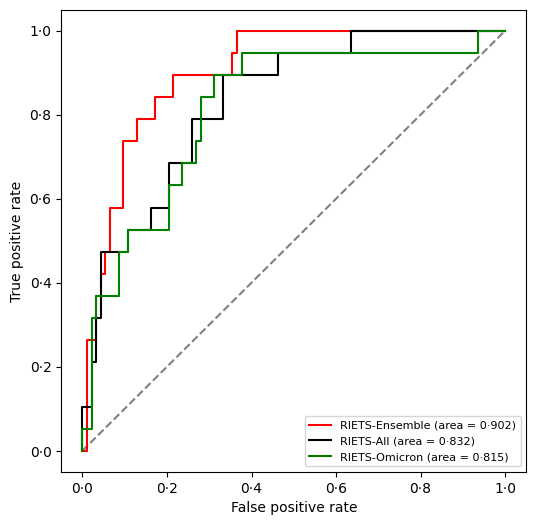

In [59]:
#AUROC plot
plt.figure(figsize=(6, 6))
plt.plot([0, 1], [0, 1], '--', color='gray')
#Ensemble Learning Trained Model 
plt.plot(Omicron_Ensemble_curve_results[0], Omicron_Ensemble_curve_results[1], color='red', label='RIETS-Ensemble (area = {:.3f})'.format(Omicron_Ensemble_curve_results[2]).replace('.', '·'))
#Whole development Trained Model
plt.plot(omicron_curve_results_all[0], omicron_curve_results_all[1], color='black', label='RIETS-All (area = {:.3f})'.format(omicron_curve_results_all[2]).replace('.', '·'))
#Independent Trained Model
plt.plot(omicron_curve_results[0], omicron_curve_results[1], color='green', label='RIETS-Omicron (area = {:.3f})'.format(omicron_curve_results[2]).replace('.', '·'))

ax = plt.gca()
# Set the formatter functions for the x and y axes of the inset plot
ax.xaxis.set_major_formatter(FuncFormatter(format_tick))
ax.yaxis.set_major_formatter(FuncFormatter(format_tick))

# Modify the ticks for the outer box
ax.set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
# plt.title("AUROC curves of COVID prediction model on Omicron Variants")
plt.legend(loc='lower right', fontsize=8)
plt.savefig('../Result/Figure_5_ROC_Plot_Omicron_cases.png', dpi=600)
plt.show()

In [57]:
#AUROC plot
# plt.figure(figsize=(6, 6))
# plt.plot([0, 1], [0, 1], '--', color='gray')
# plt.plot(alpha_curve_results_all[0], alpha_curve_results_all[1], label='Alpha (area = {:.3f})'.format(alpha_curve_results_all[2]))
# plt.plot(delta_curve_results_all[0], delta_curve_results_all[1], label='Delta (area = {:.3f})'.format(delta_curve_results_all[2]))
# plt.plot(omicron_curve_results_all[0], omicron_curve_results_all[1], label='Omicron_ALL (area = {:.3f})'.format(omicron_curve_results_all[2]))

# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title("AUROC curves of COVID Trend Analysis Trained on Whole Development Set")
# plt.legend(loc='lower right', fontsize=8)
# plt.savefig('../Result/SupplementaryFig6_Variants_AUROC_ALL.png', dpi=600)
# plt.show()

In [58]:
# ## AUROC plot
# plt.figure(figsize=(6, 6))
# plt.plot([0, 1], [0, 1], '--', color='gray')
# plt.plot(alpha_curve_results[0], alpha_curve_results[1], label='Alpha (area = {:.3f})'.format(alpha_curve_results[2]))
# plt.plot(delta_curve_results[0], delta_curve_results[1], label='Delta (area = {:.3f})'.format(delta_curve_results[2]))
# plt.plot(omicron_curve_results[0], omicron_curve_results[1], label='Omicron (area = {:.3f})'.format(omicron_curve_results[2]))
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title("AUROC curves of COVID Trend Analysis Trained and Validated on Variant Set")
# plt.legend(loc='lower right', fontsize=8)
# # plt.savefig('../Result/SupplementaryFig6_Variants_AUROC_IND.png', dpi=600)
# plt.show()